# mRNA distributions

© 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

***

In [98]:
import pandas as pd
import numpy as np

import scipy
import scipy.special

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import panel as pn

pn.extension()

### Refresher on the Poisson Distribution

As we discussed yesterday, if a gene is constitutively expressed, then its mRNA counts are expected to be Poisson distributed accross different cells. The Poisson distribution is a special case of a distribution, which is described by a single parameter $\lambda$, which is both its mean and its variance,

$$
P(x ;\lambda) = \frac{\lambda^x e^{-\lambda}}{x!}.
$$

In this notebook we will explore distributions of mRNA counts in yeast cells of two different genes, MDN1 and PDR5. The data we use in this notebook has been taken from [Zenklusen et at., 2008](https://www.nature.com/articles/nsmb.1514.pdf).

First we load in the dataset into memory.

In [122]:
df = pd.read_csv("mRNA_MDN1.csv", index_col=0)
df.head()

,mRNA_count,probability,error
0,0,0.003460,0.006055
1,1,0.027682,0.018166
2,2,0.040657,0.025087
3,3,0.092561,0.038062
4,4,0.124567,0.032872


Let's make a histogram of the data. 

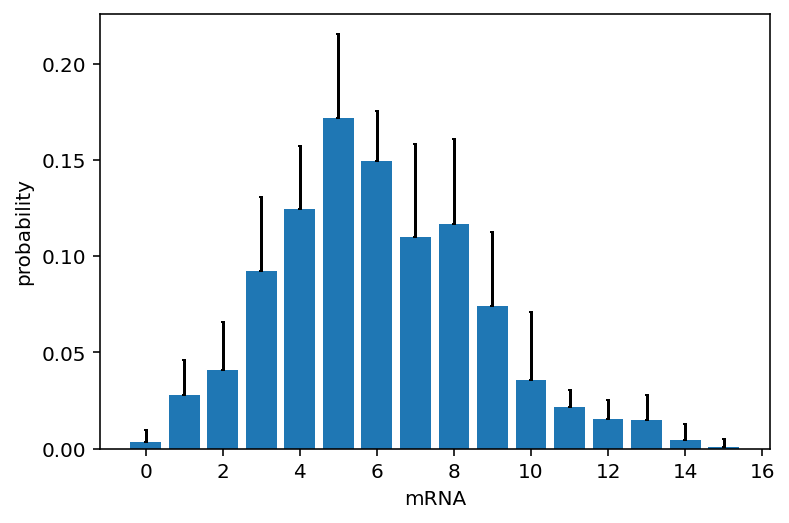

In [130]:
# Transform errors to only show positve side
error = [np.zeros(len(df)), df.error]

# Create plotting canvas
fig, ax = plt.subplots(1, 1)

# Plot bar plot
ax.bar(x=df.mRNA_count, height=df.probability, yerr=error, capsize=1)

# Label Axes
ax.set_ylabel("probability")
ax.set_xlabel("mRNA");

A good first step is to eyeball a distribution that might work with the data. The data we plotted looks like a Poisson distribution might work well here. So let's plot one on top of the data and see which parameter works well.

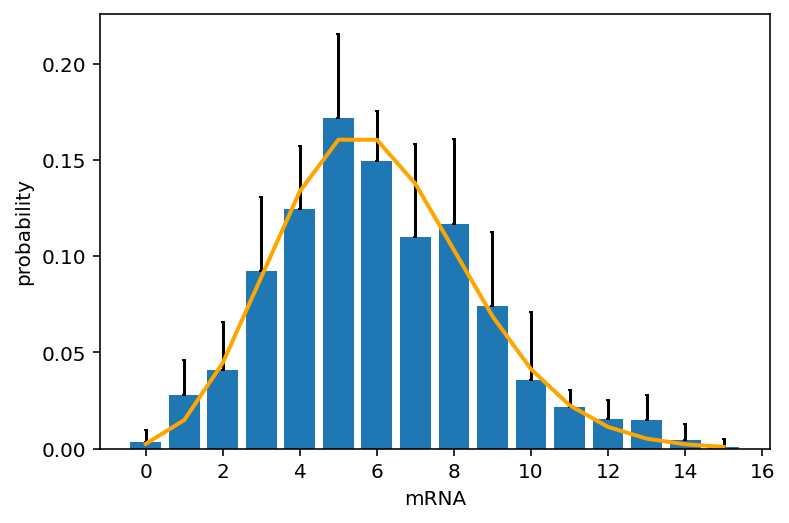

In [131]:
# Function for PMF of Poission distribution
poisson = lambda m, x: m**x / scipy.math.factorial(x) * np.exp(-m)

# Compute PMF
λ = 6
poisson_dist = [poisson(λ, x) for x in df.mRNA_count]

# Plot PMF
ax.plot(np.arange(len(df)), poisson_dist, color="orange", lw=2)
fig

This works really well. If we would try to come to a scientific conclusion on which parameter works best for the Poisson distribution, we would to perform a much more thorough investigation if the data, but for the purpose of this notebook, this is enough.

Let's proceed with the second dataset for the gene PDR5.

In [132]:
df_2 = pd.read_csv("mRNA_PDR5.csv", index_col=0)
df_2.head()

,mRNA_count,probability,error
0,0,0.007862,0.007448
1,1,0.007034,0.007448
2,2,0.013655,0.013241
3,3,0.033517,0.031862
4,4,0.035172,0.010759


Again we plot a histogram of the data.

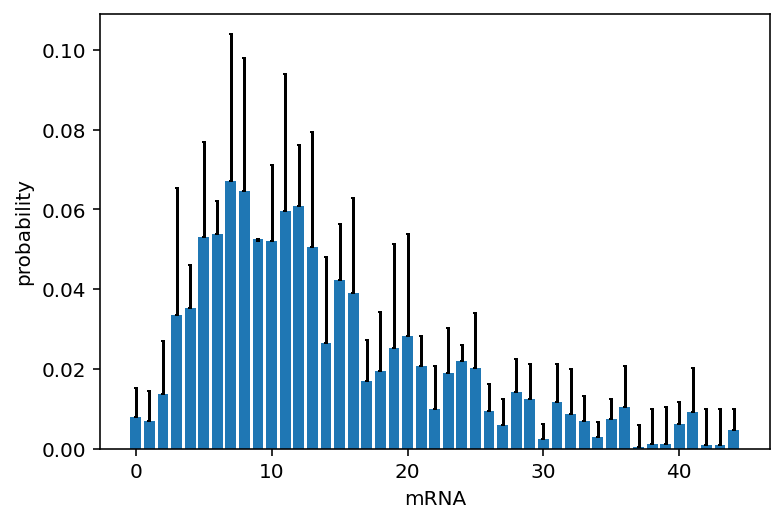

In [133]:
error = [np.zeros(len(df_2)), df_2.error]
fig2, ax2 = plt.subplots(1, 1)

ax2.bar(x=df_2.mRNA_count, height=df_2.probability, yerr=error, capsize=1)
ax2.set_ylabel("probability")
ax2.set_xlabel("mRNA");

Let's try to plot a Poisson distribution on top of this data.

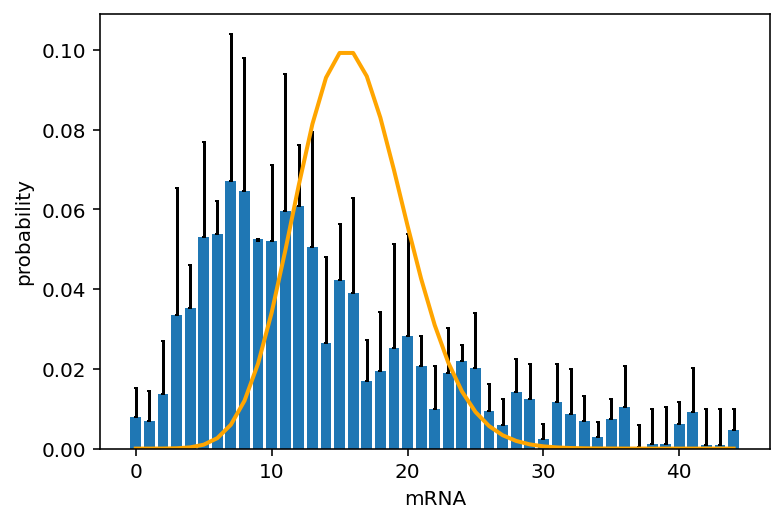

In [120]:
poisson_dist = [poisson(16, x) for x in df_2.mRNA_count]
ax2.plot(np.arange(len(df_2)), poisson_dist, color="orange", lw=2)
fig2

Before we proceed with finding a better distribution for 

Row
    [0] Column
        [0] Markdown(str)
        [1] FloatSlider(end=10, name='Poisson Mean for MDN1', step=1, value=1)
        [2] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] FloatSlider(end=10, name='Poisson Mean for PDR5', step=1, value=1)
        [2] ParamFunction(function)
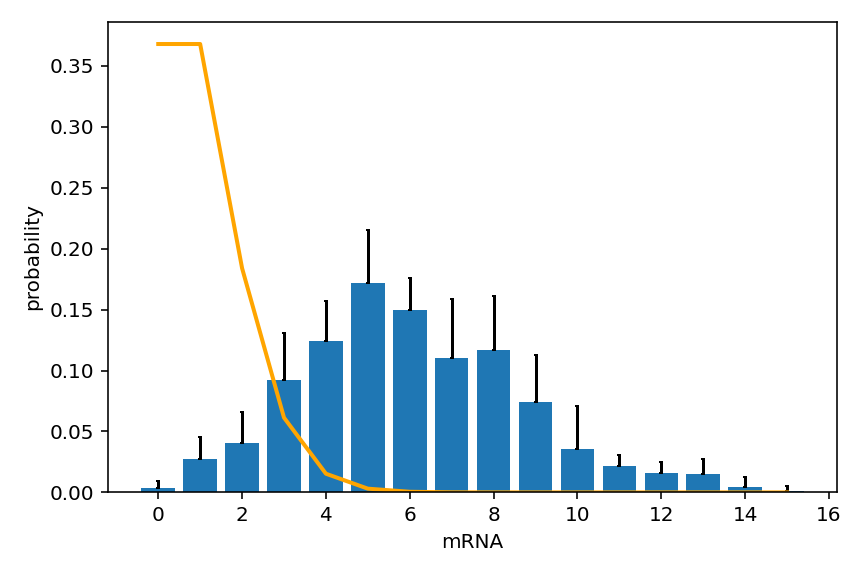
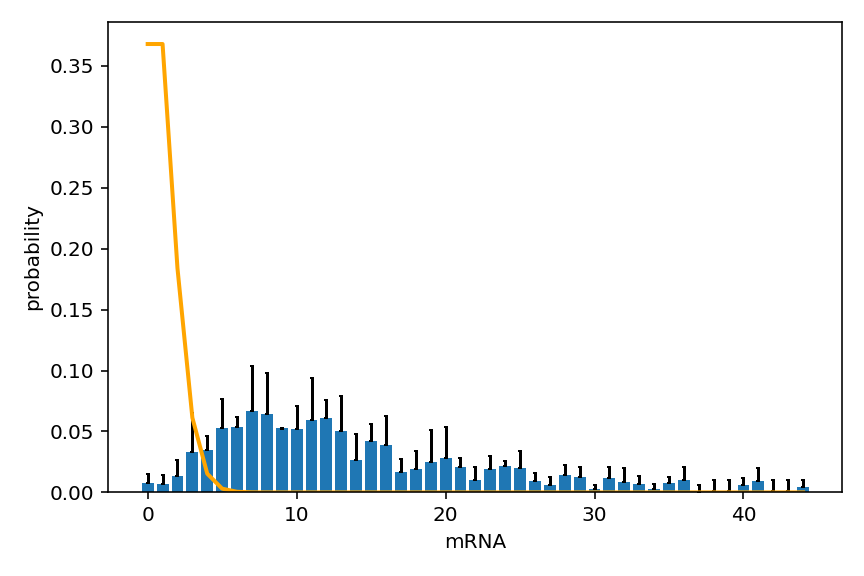

In [129]:
# Define slider for coin bias
mean_MDN1_slider = pn.widgets.FloatSlider(
    name='Poisson Mean for MDN1',
    start=0,
    end=10,
    step=1,
    value=1
)

mean_PDR5_slider = pn.widgets.FloatSlider(
    name='Poisson Mean for PDR5',
    start=0,
    end=10,
    step=1,
    value=1
)


@pn.depends(mean_MDN1_slider)
def interact_poisson_MDN1(poiss_mean):
    error = [np.zeros(len(df)), df.error]
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.bar(x=df.mRNA_count, height=df.probability, yerr=error, capsize=1)
    ax.set_ylabel("probability")
    ax.set_xlabel("mRNA")
    poisson_dist = [poisson(poiss_mean, x) for x in df.mRNA_count]
    ax.plot(
        np.arange(len(df)), 
        poisson_dist, 
        color="orange", 
        lw=2
    )
    fig.tight_layout()
    plt.close(fig)
    return fig


@pn.depends(mean_PDR5_slider)
def interact_poisson_PDR5(poiss_mean):
    error = [np.zeros(len(df_2)), df_2.error]
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.bar(x=df_2.mRNA_count, height=df_2.probability, yerr=error, capsize=1)
    ax.set_ylabel("probability")
    ax.set_xlabel("mRNA")
    poisson_dist = [poisson(poiss_mean, x) for x in df_2.mRNA_count]
    ax.plot(
        np.arange(len(df_2)), 
        poisson_dist, 
        color="orange", 
        lw=2
    )
    fig.tight_layout()
    plt.close(fig)
    return fig

pn.Row(
    pn.Column(
        '## MDN1',
        mean_MDN1_slider,
        interact_poisson_MDN1
    ),
    pn.Column(
        '## PDR5',
        mean_PDR5_slider,
        interact_poisson_PDR5
    ),
)

It seems like we cannot find a parameter that gives a Poisson distribution that fits the data well. This means that we need to find a different model that works better with our data. A common observation in mammals is the one of bursty transcription, where instead of a continuous level of transcription, many mRNAs are produced in a short time, followed by a period of close to no transcription at all. The Poisson distribution does not work for bursty transcription. Instead, a better distribution is the so-called Negative Binomial Distribution.

### Negative Binomial Distribution.

"We perform a series of Bernoulli trials with probability $\beta/1+\beta$ of success. The number of failures, 𝑦, before we get 𝛼 successes is Negative Binomially distributed."

"Bursty gene expression can give mRNA count distributions that are Negative Binomially distributed. Here, “success” is that a burst in gene expression stops. In this case, the parameter 1/𝛽 is the mean number of transcripts in a burst of expression. The parameter $\alpha$ is related to the frequency of the bursts. If multiple bursts are possible within the lifetime of mRNA, then 𝛼>1. Then, the number of “failures” is the number of mRNA transcripts that are made in the characteristic lifetime of mRNA.

-[Probability Distribution Explorer](https://distribution-explorer.github.io/discrete/negative_binomial.html)

This seems to be a great fit for what we are trying to do here. The PMF of the Negative Binomial distribution is given by

$$
P(x; \alpha, \beta) = \frac{\Gamma(\alpha + x)}{\Gamma(\alpha)x!} \left(\frac{\beta}{\beta+1}\right)^x \left(\frac{1}{1+\beta}\right)^\alpha,
$$

where $\Gamma(y)$ is the Gamma function. We will not go into more detail here or derive this distribution. If you are interested in a more detailed discussion on bursty transcription and the Negative Binomial function, check out this [notebook](http://be150.caltech.edu/2019/handouts/11_bursty.html) from the class Be150 by Justin Bois and Michael Ellowitz (which I took myself and highly recommend)

Row
    [0] Column
        [0] Markdown(str)
        [1] FloatSlider(end=100, name='α', step=1, value=1)
        [2] FloatSlider(name='β', step=0.01, value=0.1)
        [3] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] FloatSlider(end=10, name='α', step=1, value=1)
        [2] FloatSlider(end=10, name='β', step=1, value=1)
        [3] ParamFunction(function)
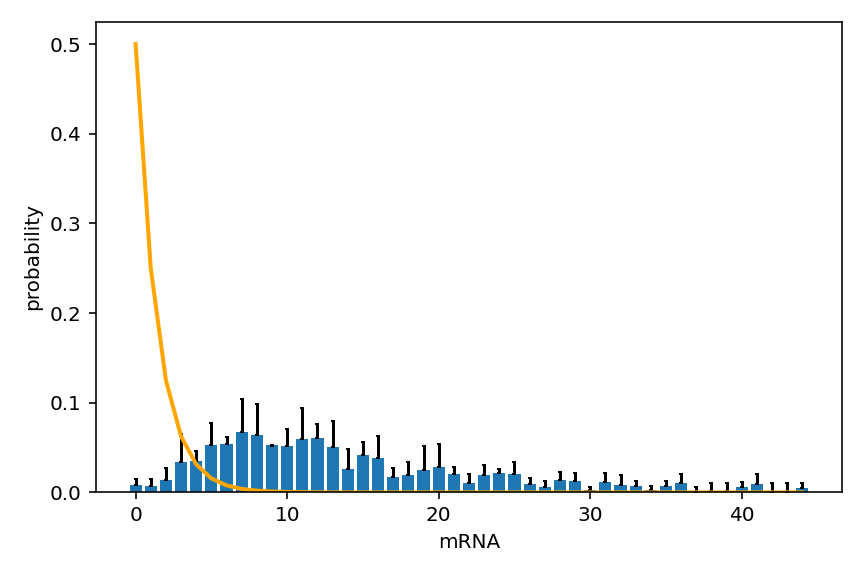
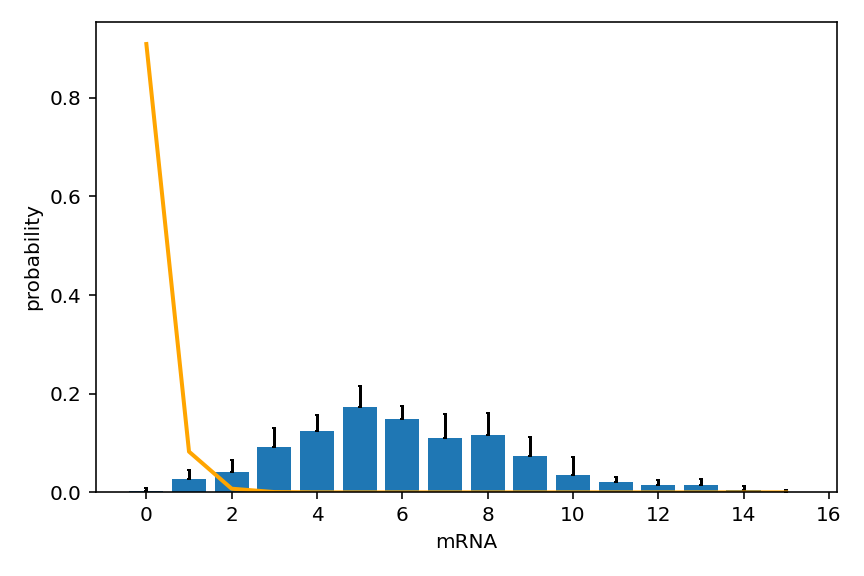

In [141]:
# Function for PMF of Negative Binomial distribution
neg_binom = lambda x, α, β: scipy.special.gamma(α + x) /(scipy.special.gamma(α) * scipy.math.factorial(x)) \
    * (β / (1 + β))**x * (1 / (1 + β))**α
    

# Define sliders for MDN1 
α_MDN1_slider = pn.widgets.FloatSlider(
    name='α',
    start=0,
    end=100,
    step=1,
    value=1
)

# Define sliders for PDR5
β_MDN1_slider = pn.widgets.FloatSlider(
    name='β',
    start=0,
    end=1,
    step=0.01,
    value=0.1
)

# Define sliders for PDR5
α_PDR5_slider = pn.widgets.FloatSlider(
    name='α',
    start=0,
    end=10,
    step=1,
    value=1
)

# Define sliders for PDR5
β_PDR5_slider = pn.widgets.FloatSlider(
    name='β',
    start=0,
    end=10,
    step=1,
    value=1
)


@pn.depends(α_MDN1_slider, β_MDN1_slider)
def interact_poisson_MDN1(α, β):
    error = [np.zeros(len(df)), df.error]
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.bar(x=df.mRNA_count, height=df.probability, yerr=error, capsize=1)
    ax.set_ylabel("probability")
    ax.set_xlabel("mRNA")
    neg_binom_dist = [neg_binom(x, α, β) for x in df.mRNA_count]
    ax.plot(
        np.arange(len(df)), 
        neg_binom_dist, 
        color="orange", 
        lw=2
    )
    fig.tight_layout()
    plt.close(fig)
    return fig


@pn.depends(α_PDR5_slider, β_PDR5_slider)
def interact_poisson_PDR5(α, β):
    error = [np.zeros(len(df_2)), df_2.error]
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.bar(x=df_2.mRNA_count, height=df_2.probability, yerr=error, capsize=1)
    ax.set_ylabel("probability")
    ax.set_xlabel("mRNA")
    neg_binom_dist = [neg_binom(x, α, β) for x in df_2.mRNA_count]
    ax.plot(
        np.arange(len(df_2)), 
        neg_binom_dist, 
        color="orange", 
        lw=2
    )
    fig.tight_layout()
    plt.close(fig)
    return fig

pn.Row(
    pn.Column(
        '## MDN1',
        α_MDN1_slider,
        β_MDN1_slider,
        interact_poisson_MDN1
    ),
    pn.Column(
        '## PDR5',
        α_PDR5_slider,
        β_PDR5_slider,
        interact_poisson_PDR5
    ),
)

We can find parameters for both data sets such that the Negative Binomial distributions seems to be a good fit. This is not a contradiction to our previous observation that the Poisson distribution was a good fit for the MDN1 data set. In the limit of $\alpha\rightarrow \infty,\,\beta\rightarrow 0$, the Negative Binomial distribution converges to the Poisson distribution! So everything is consistent. We can also see that the Negative Binomial distribution is a much better fit for the PDR5 dataset than the Poisson distribution, suggesting that this gene is object to bursty transcription.

In [142]:
import os
os.getcwd()

'/Users/tomroschinger/git/be262/code/2021'